# Benchmark Model

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = "/content/drive/My Drive/Taller_diseño_proyecto/data_academic_performance.xlsx"

df_raw = pd.read_excel(path)
df = df_raw.drop(columns=['COD_S11', 'STRATUM', 'SISBEN', 'Unnamed: 9', 'DVD', 'FRESH', 'REVENUE',
                          'SCHOOL_NAME'])
df.drop(df.columns[22:], axis=1, inplace=True)
df.dropna(inplace=True)
df.head()

,GENDER,EDU_FATHER,EDU_MOTHER,OCC_FATHER,OCC_MOTHER,PEOPLE_HOUSE,INTERNET,TV,COMPUTER,WASHING_MCH,MIC_OVEN,CAR,PHONE,MOBILE,JOB,SCHOOL_NAT,SCHOOL_TYPE,MAT_S11,CR_S11,CC_S11,BIO_S11,ENG_S11
0,F,Incomplete Professional Education,Complete technique or technology,Technical or professional level employee,Home,Three,Yes,Yes,Yes,Yes,No,No,Yes,Yes,No,PRIVATE,ACADEMIC,71,81,61,86,82
1,F,Complete Secundary,Complete professional education,Entrepreneur,Independent professional,Three,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,PRIVATE,ACADEMIC,83,75,66,100,88
2,M,Not sure,Not sure,Independent,Home,Five,No,No,Yes,Yes,No,No,Yes,No,"Yes, 20 hours or more per week",PRIVATE,ACADEMIC,52,49,38,46,42
3,F,Not sure,Not sure,Other occupation,Independent,Three,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,PRIVATE,ACADEMIC,56,55,51,64,73
4,M,Complete professional education,Complete professional education,Executive,Home,One,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,PRIVATE,ACADEMIC,80,65,76,85,92


### Pre-processing

In [8]:
df['OCC_FATHER'].unique()

array(['Technical or professional level employee', 'Entrepreneur ',
       'Independent', 'Other occupation', 'Executive',
       'Small entrepreneur ', 'Independent professional', 'Operator', 0,
       'Retired', 'Auxiliary or Administrative', 'Home'], dtype=object)

In [9]:
# gender
dic_gender ={'M': 0, 'F': 1}
df.replace({'GENDER': dic_gender}, inplace=True)

# education father
df.loc[df['EDU_FATHER'] == "Ninguno", "EDU_FATHER"] = "None"
# We asumme 0 is no answer, so we drop it
df.drop(df.loc[df['EDU_FATHER'] == 0].index, inplace=True)
dic_edu = {'Postgraduate education': 10, 'Complete professional education': 9, 'Complete technique or technology': 8,
              'Incomplete Professional Education': 7,'Incomplete technical or technological': 6, 'Complete Secundary': 5,
              'Incomplete Secundary': 4, 'Complete primary ': 3, 'Incomplete primary ': 2, 'None': 1, 'Not sure': 0}
df.replace({'EDU_FATHER': dic_edu}, inplace=True)

# education mother
df.loc[df['EDU_MOTHER'] == "Ninguno", "EDU_MOTHER"] = "None"
# We asumme 0 is no answer, so we drop it
df.drop(df.loc[df['EDU_MOTHER'] == 0].index, inplace=True)
df.replace({'EDU_MOTHER': dic_edu}, inplace=True)

# ocuupation father
df.drop(df.loc[df['OCC_FATHER'] == 0].index, inplace=True)
dic_occ = {'Home': 0, 'Retired': 1, 'Other occupation': 2, 'Small entrepreneur ': 3, 'Entrepreneur ': 4,
             'Operator': 5, 'Executive': 6, 'Independent professional': 7, 'Independent': 8, 'Auxiliary or Administrative': 9,
             'Technical or professional level employee': 10}
df.replace({'OCC_FATHER': dic_occ}, inplace=True)

# occupation mother
df.drop(df.loc[df['OCC_MOTHER'] == 0].index, inplace=True)
df.replace({'OCC_MOTHER': dic_occ}, inplace=True)

# people in the house
dictionary = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8,
       'Nueve': 9, 'Ten': 10, 'Once': 11, 'Twelve or more': 12}
df.replace({'PEOPLE_HOUSE': dictionary}, inplace=True)

dic_yes_no = {'No': 0, 'Yes': 1}

# internet
df.replace({'INTERNET': dic_yes_no}, inplace=True)

# tv
df.replace({'TV': dic_yes_no}, inplace=True)

# computer
df.replace({'COMPUTER': dic_yes_no}, inplace=True)

# washing machine
df.replace({'WASHING_MCH': dic_yes_no}, inplace=True)

# microwave
df.replace({'MIC_OVEN': dic_yes_no}, inplace=True)

# car
df.replace({'CAR': dic_yes_no}, inplace=True)

# landline
df.replace({'PHONE': dic_yes_no}, inplace=True)

# cell phone
df.replace({'MOBILE': dic_yes_no}, inplace=True)

# job
df.drop(df.loc[df['JOB'] == 0].index, inplace=True)
dic_job = {'No': 0, 'Yes, less than 20 hours per week': 1, 'Yes, 20 hours or more per week': 2}
df.replace({'JOB': dic_job}, inplace=True)

# naturality of school
dic_nat = {'PUBLIC': 0, 'PRIVATE': 1}
df.replace({'SCHOOL_NAT': dic_nat}, inplace=True)

# type of school
df.drop(df.loc[df['SCHOOL_TYPE'] == 'Not apply'].index, inplace=True)
dic_school_type = {'ACADEMIC': 2, 'TECHNICAL/ACADEMIC': 1, 'TECHNICAL': 0}
df.replace({'SCHOOL_TYPE': dic_school_type}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11441 entries, 0 to 12410
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   GENDER        11441 non-null  int64
 1   EDU_FATHER    11441 non-null  int64
 2   EDU_MOTHER    11441 non-null  int64
 3   OCC_FATHER    11441 non-null  int64
 4   OCC_MOTHER    11441 non-null  int64
 5   PEOPLE_HOUSE  11441 non-null  int64
 6   INTERNET      11441 non-null  int64
 7   TV            11441 non-null  int64
 8   COMPUTER      11441 non-null  int64
 9   WASHING_MCH   11441 non-null  int64
 10  MIC_OVEN      11441 non-null  int64
 11  CAR           11441 non-null  int64
 12  PHONE         11441 non-null  int64
 13  MOBILE        11441 non-null  int64
 14  JOB           11441 non-null  int64
 15  SCHOOL_NAT    11441 non-null  int64
 16  SCHOOL_TYPE   11441 non-null  int64
 17  MAT_S11       11441 non-null  int64
 18  CR_S11        11441 non-null  int64
 19  CC_S11        11441 non-n

### Split into training and test sets

Primero vamos a probar con un modelo que entregue un apredicción del desemepeño de los estudiantes en todos las materias

In [10]:
# first, we shuffle the observations
df = df.sample(frac=1).reset_index(drop=True)

# percentage of trainign data
per_train = 0.8
num_samples = df.shape[0]
num_train = int(num_samples * per_train) + 1

# training data
train_set = df.iloc[:num_train]
# test set
test_set = df.iloc[num_train:]

X_train = train_set.iloc[:, :17].to_numpy()
Y_train = train_set.iloc[:, 17:].to_numpy()

X_test = test_set.iloc[:, :17].to_numpy()
Y_test = test_set.iloc[:, 17:].to_numpy()

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(9153, 17) (2288, 17)
(9153, 5) (2288, 5)


## Training Model

In [11]:
# creating model
model = DecisionTreeRegressor()

In [12]:
# trainign model
model.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

### Results

In [13]:
preds = model.predict(X_test)

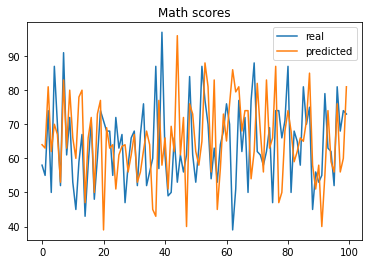

MSE: 15.379719121478315


In [33]:
# math
x = range(Y_test.shape[0])
# print(x)
# print(len(Y_test[:, 0]))
plt.plot(x[:100], Y_test[:100, 0].reshape(-1), label = "real")
plt.plot(x[:100], preds[:100, 0], label = "predicted")
plt.title("Math scores")
plt.legend()
plt.show()

print('MSE:', sqrt(mean_squared_error(Y_test[:, 0], preds[:, 0])))

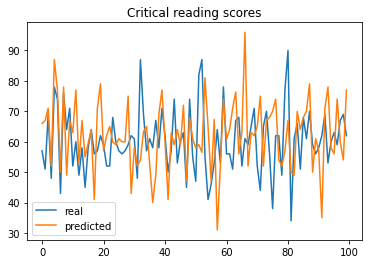

MSE: 13.906165242182112


In [35]:
# critical reading
x = range(Y_test.shape[0])
# print(x)
# print(len(Y_test[:, 0]))
plt.plot(x[:100], Y_test[:100, 1].reshape(-1), label = "real")
plt.plot(x[:100], preds[:100, 1], label = "predicted")
plt.title("Critical reading scores")
plt.legend()
plt.show()

print('MSE:', sqrt(mean_squared_error(Y_test[:, 1], preds[:, 1])))

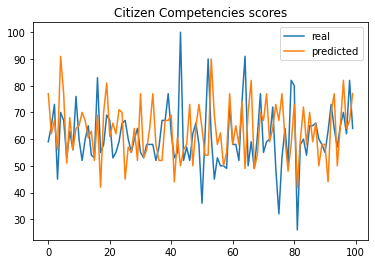

MSE: 14.130455357684792


In [36]:
# Citizen Competencies
x = range(Y_test.shape[0])
# print(x)
# print(len(Y_test[:, 0]))
plt.plot(x[:100], Y_test[:100, 2].reshape(-1), label = "real")
plt.plot(x[:100], preds[:100, 2], label = "predicted")
plt.title("Citizen Competencies scores")
plt.legend()
plt.show()

print('MSE:', sqrt(mean_squared_error(Y_test[:, 2], preds[:, 2])))

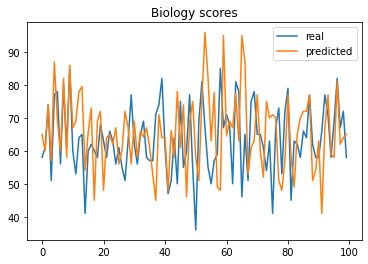

MSE: 15.34882027944498


In [37]:
# biology
x = range(Y_test.shape[0])
# print(x)
# print(len(Y_test[:, 0]))
plt.plot(x[:100], Y_test[:100, 3].reshape(-1), label = "real")
plt.plot(x[:100], preds[:100, 3], label = "predicted")
plt.title("Biology scores")
plt.legend()
plt.show()

print('MSE:', sqrt(mean_squared_error(Y_test[:, 3], preds[:, 3])))

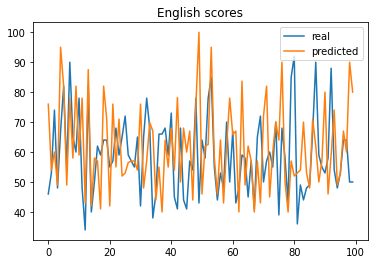

MSE: 17.01639779072476


In [38]:
# english
x = range(Y_test.shape[0])
# print(x)
# print(len(Y_test[:, 0]))
plt.plot(x[:100], Y_test[:100, 4].reshape(-1), label = "real")
plt.plot(x[:100], preds[:100, 4], label = "predicted")
plt.title("English scores")
plt.legend()
plt.show()

print('MSE:', sqrt(mean_squared_error(Y_test[:, 4], preds[:, 4])))